In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
#manifest_file = r'/Users/saskiad/Code/brain_observatory/manifest_v1point3.json'
#boc = BrainObservatoryCache(manifest_file=manifest_file)
boc = BrainObservatoryCache()

# Getting data from a session

We're going to examine the data available for a single session. First, let's identify the session from the experiment container we explored in vc2p-dataset in which that "natural scenes" stimulus was presented.

In [3]:
experiment_container_id = 511510736
session_id = boc.get_ophys_experiments(experiment_container_ids=[experiment_container_id], stimuli=['natural_scenes'])[0]['id']

We can use this session_id to get all the data contained in the NWB for this session using <b>get_ophys_experiment_data</b>

In [4]:
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

## Maximum projection
This is the projection of the full motion corrected movie. It shows all of the cells imaged during the session.

In [5]:
max_projection = data_set.get_max_projection()

(-0.5, 511.5, 511.5, -0.5)

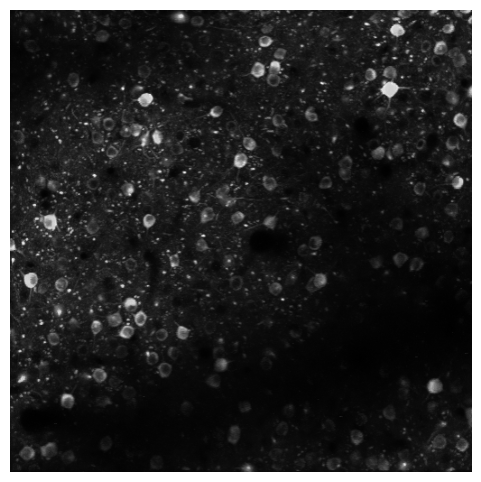

In [6]:
fig = plt.figure(figsize=(6,6))
plt.imshow(max_projection, cmap='gray')
plt.axis('off')

## ROI Masks
These are all of the segmented masks for cell bodies identified in this session.

In [7]:
rois = data_set.get_roi_mask_array()

What is the shape of this array? How many neurons are in this experiment?

In [8]:
rois.shape

(174, 512, 512)

The first dimension of this array is the number of neurons, and each element of this axis is the mask of an individual neuron

Plot the masks for all the ROIs.

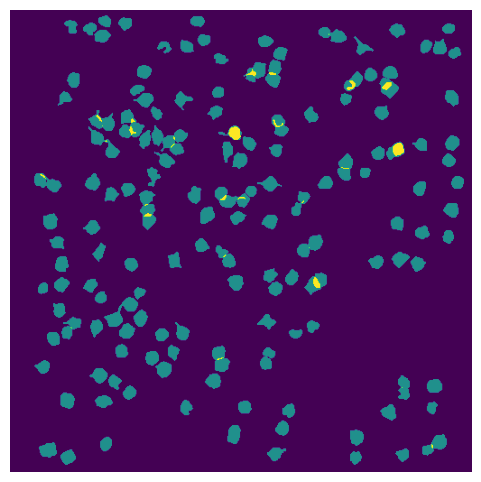

In [9]:
fig = plt.figure(figsize=(6,6))
plt.imshow(rois.sum(axis=0))
plt.axis('off');

## Fluorescence and DF/F traces
The NWB file contains a number of traces reflecting the processing that is done to the extracted fluorescence before we analyze it. The fluorescence traces are the mean fluorescence of all the pixels contained within a ROI mask.

There are a number of activity traces accessible in the NWB file, including raw fluorescence, neuropil corrected traces, demixed traces, and DF/F traces.

In [10]:
timestamps,fluor = data_set.get_fluorescence_traces()

To correct from contamination from the neuropil, we perform neuropil correction. First, we extract a local neuropil signal, by creating a neuropil mask that is an annulus around the ROI mask (without containing any pixels from nearby neurons). You can see these neuropil signals in the neuropil traces:

In [11]:
timestamps, np = data_set.get_neuropil_traces()

This neuropil trace is subtracted from the fluorescence trace, after being weighted by a factor that is computed for each neuron. The resulting corrected fluorescence trace is accessed here:

In [12]:
timestamps,cor = data_set.get_corrected_fluorescence_traces()

Let's look at these traces for one cell:

(1900.0, 2200.0)

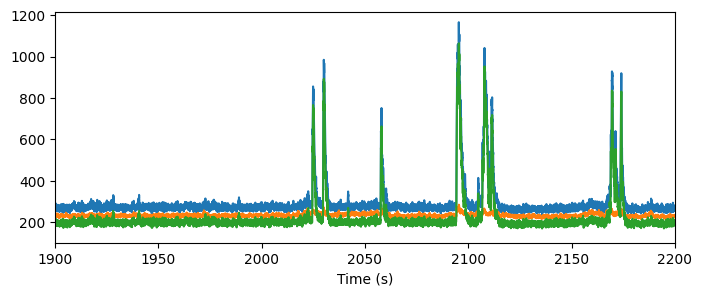

In [13]:
fig = plt.figure(figsize=(8,3))
plt.plot(timestamps, fluor[122,:])
plt.plot(timestamps, np[122,:])
plt.plot(timestamps, cor[122,:])
plt.xlabel("Time (s)")
plt.xlim(1900,2200)

(demixing?)

The signal we are most interested in the the DF/F - the change in fluorescence normalized by the baseline fluorescence.

In [14]:
ts, dff = data_set.get_dff_traces()

Text(0, 0.5, 'DFF')

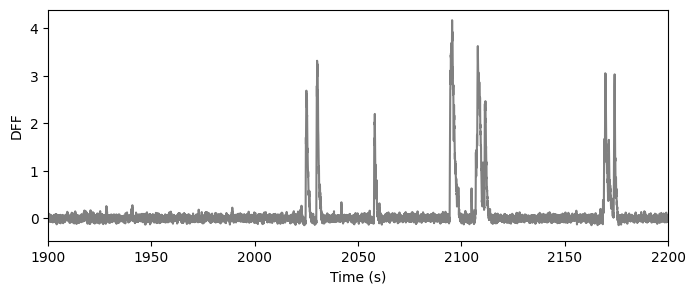

In [15]:
fig = plt.figure(figsize=(8,3))
plt.plot(ts, dff[122,:], color='gray')
plt.xlabel("Time (s)")
plt.xlim(1900,2200)
plt.ylabel("DFF")

## Extracted events
As of the October 2018 data release, we are providing access to events extracted from the DF/F traces using the L0 method developed by Sean Jewell and Daniella Witten. 
```{note} 
The extracted events are not stored in the NWB file, thus aren't a function of the data_set object, but are available through the boc
```

In [16]:
events = boc.get_ophys_experiment_events(ophys_experiment_id=session_id)

2023-06-15 21:52:23,845 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/739721211


Text(0, 0.5, 'DFF')

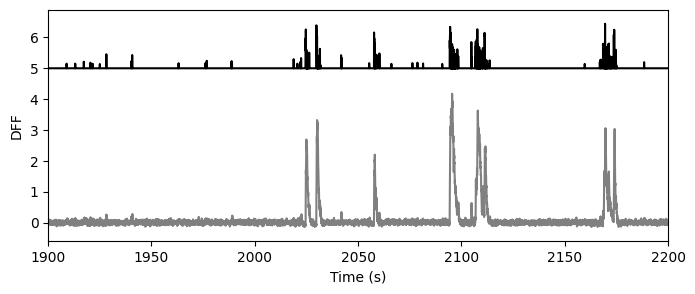

In [17]:
fig = plt.figure(figsize=(8,3))
plt.plot(ts, dff[122,:], color='gray')
plt.plot(ts, 2*events[122,:]+5, color='black')
plt.xlabel("Time (s)")
plt.xlim(1900,2200)
plt.ylabel("DFF")

## Stimulus epochs

Several stimuli are shown during each imaging session, interleaved with each other. The stimulus epoch table provides information of these interleaved stimulus epochs, revealing when each epoch begins and ends. The start and end here are provided in terms of the imaging frame of the two-photon imaging. This allows us to index directly into the dff or event traces.

In [18]:
stim_epoch = data_set.get_stimulus_epoch_table()
stim_epoch

,stimulus,start,end
0,static_gratings,747,15196
1,natural_scenes,16100,30551
2,spontaneous,30701,39581
3,natural_scenes,39582,54050
4,static_gratings,54953,69403
5,natural_movie_one,70307,79338
6,natural_scenes,80241,96126
7,static_gratings,97406,113662


Let's plot the DFF traces of a number of cells and overlay stimulus epochs.

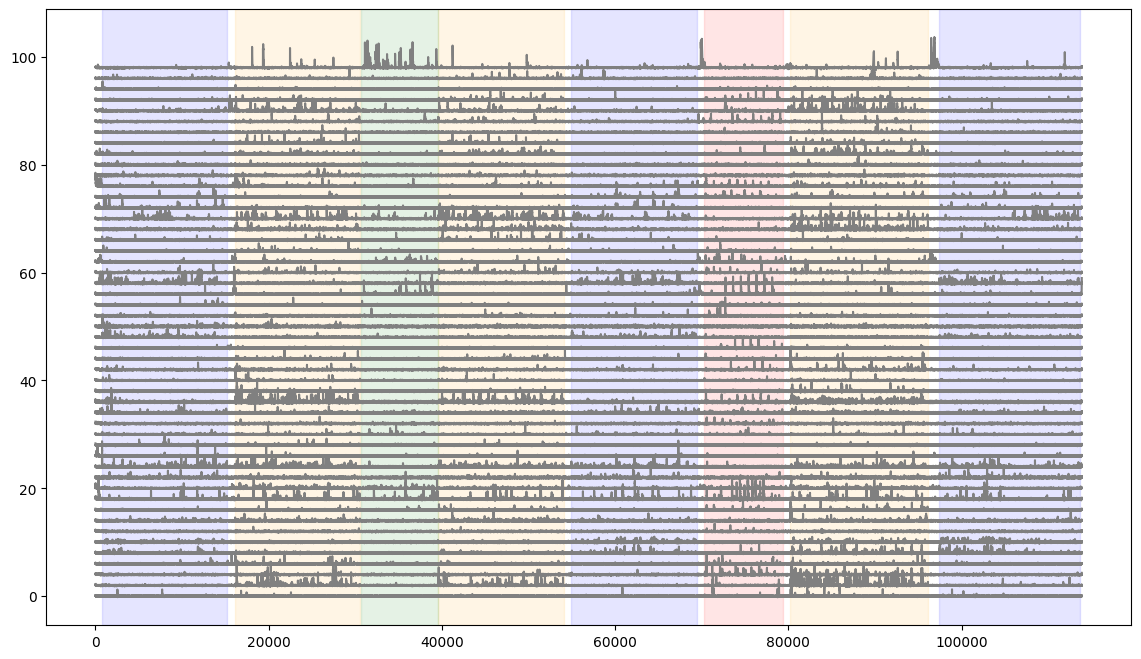

In [19]:
fig = plt.figure(figsize=(14,8))

#here we plot the first 50 neurons in the session
for i in range(50):
    plt.plot(dff[i,:]+(i*2), color='gray')
    
#here we shade the plot when each stimulus is presented
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)

## Running speed

The running speed of the animal on the rotating disk during the entire session. This has been temporally aligned to the two photon imaging, so you will find that it has the same length as dff.

In [20]:
dxcm, timestamps = data_set.get_running_speed()
print("length of dff: ", str(len(dff)))
print("length of running speed: ", str(len(dxcm)))

length of dff:  174
length of running speed:  113888


Plot the running speed.

Text(0, 0.5, 'Running speed (cm/s)')

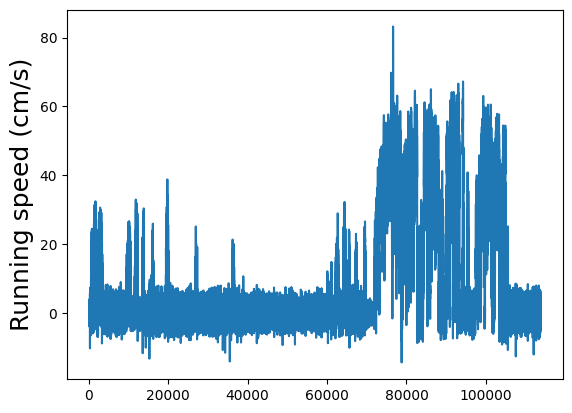

In [21]:
plt.plot(dxcm)
plt.ylabel("Running speed (cm/s)", fontsize=18)

Add the running speed to the neural activity and stimulus epoch figure

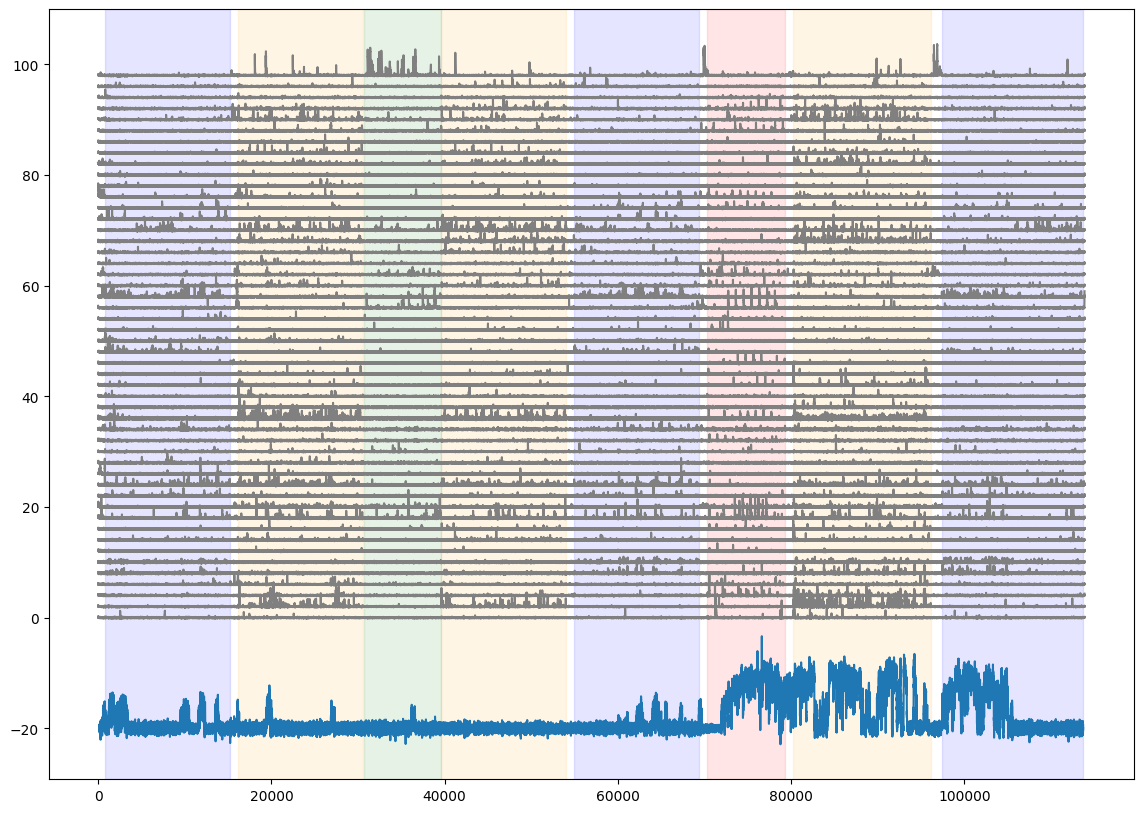

In [22]:
fig = plt.figure(figsize=(14,10))
for i in range(50):
    plt.plot(dff[i,:]+(i*2), color='gray')
plt.plot((0.2*dxcm)-20)
    
#for each stimulus, shade the plot when the stimulus is presented
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)

## Cell ids and indices

Each neuron in the dataset has a unique id, called the <b>cell specimen id</b>. To find the neurons in this session, get the cell specimen ids. This id can also be used to identify experiment containers or sessions where a given neuron is present

In [23]:
cell_ids = data_set.get_cell_specimen_ids()
cell_ids

array([517473350, 517473341, 517473313, 517473255, 517471959, 517471769,
       517473059, 517471997, 517472716, 517471919, 517472989, 517472293,
       517473115, 517472454, 517473020, 517472734, 517474366, 587377483,
       517471708, 587377366, 587377223, 517474444, 517474437, 517473105,
       517472300, 517472326, 517472708, 517472215, 517472712, 517472360,
       517472399, 517472197, 517472582, 517472190, 517473926, 587377518,
       517471931, 517472637, 517472416, 517471658, 517472724, 517472684,
       517471664, 587377211, 517473947, 587377064, 517472063, 587377621,
       517473080, 517472553, 517473001, 517474078, 517471794, 517471674,
       517473916, 517471803, 517472592, 517473014, 517474459, 517472241,
       517472720, 517472534, 517472054, 587377662, 517474012, 517474020,
       517473653, 517472007, 517472645, 517472211, 517472677, 517472731,
       517472621, 517472442, 587377204, 517473027, 517472818, 517473304,
       517474121, 517473034, 517472909, 517473624, 

Within each individual session, a cell id is associated with an index. This index maps into the dff or event traces.  Pick one cell id from the list above and find the index for that neuron.

In [24]:
data_set.get_cell_specimen_indices([517473110])

[110]

```{note}
As neurons are often matched across sessions, that neuron will have the same cell specimen id in all said sessions, but it will have a different cell specimen index in each session.
```

(reference exercise, plot the movie response for a cell across three different sessions)


## Stimulus Table
(make this a new page and look at other sessions?)
For each stimulus there is a stimulus table with information about the condition and timing of each trial.

In [25]:
natural_scene_table = data_set.get_stimulus_table('natural_scenes')

In [26]:
natural_scene_table.head()

,frame,start,end
0,81,16100,16107
1,33,16108,16115
2,76,16115,16122
3,13,16123,16130
4,56,16130,16137


Get the stimulus table for static gratings. Print the top of this dataframe. What are the parameters for this stimulus?

In [27]:
static_gratings_table = data_set.get_stimulus_table('static_gratings')

In [28]:
static_gratings_table.head()

,orientation,spatial_frequency,phase,start,end
0,90.0,0.04,0.50,747,754
1,150.0,0.04,0.50,754,761
2,30.0,0.02,0.00,762,769
3,0.0,0.32,0.50,769,776
4,150.0,0.16,0.75,777,784
